In [1]:
import utils
import pandas as pd
from umap import UMAP
import plotly.express as px
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy
import seaborn as sns

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

In this notebook, the negcon normalized profiles are projected onto UMAP dimensions. Replicates are collapsed to consensus profiles and the UMAP representations are plotted. Correlations are plotted as heatmap and hierarchical clustering is plotted as a dendogram.

In [2]:
experiment_df = pd.read_csv('output/experiment-metadata.tsv', sep='\t')

In [3]:
all_plates_df = pd.DataFrame()

for i, plate in enumerate(experiment_df.Assay_Plate_Barcode.unique()):
    batch = experiment_df.loc[i, 'Batch']
    df = (
        pd.read_csv(f'../profiles/{batch}/{plate}/{plate}_normalized_negcon.csv.gz')
    )
    all_plates_df = utils.concat_profiles(all_plates_df, df)

all_plates_df = utils.remove_all_control_empty_wells(all_plates_df)
all_plates_df = all_plates_df.replace(np.inf, np.nan).dropna(axis=1,how="any")

all_plates_conc_1_df = utils.remove_all_control_empty_wells(all_plates_df.query('Metadata_mmoles_per_liter==1'))
all_plates_conc_4_df = utils.remove_all_control_empty_wells(all_plates_df.query('Metadata_mmoles_per_liter==4'))

all_plates_conc_1_consensus_df = utils.consensus(all_plates_conc_1_df, 'Metadata_broad_sample')
all_plates_conc_4_consensus_df = utils.consensus(all_plates_conc_4_df, 'Metadata_broad_sample')

In [4]:
X_1 = utils.get_featuredata(all_plates_conc_1_consensus_df)
X_4 = utils.get_featuredata(all_plates_conc_4_consensus_df)

umap_2d = UMAP(n_components=2, init='random', random_state=9000)
X_1_embedded = umap_2d.fit_transform(X_1)
X_4_embedded = umap_2d.fit_transform(X_4)

In [5]:
Compound_1 = list(all_plates_conc_1_consensus_df.Metadata_broad_sample)
Compound_4 = list(all_plates_conc_4_consensus_df.Metadata_broad_sample)
row_1 = list(all_plates_conc_1_df.Metadata_Well.drop_duplicates().str[0:1])
col_1 = list(all_plates_conc_1_df.Metadata_Well.drop_duplicates().str[1:])
row_4 = list(all_plates_conc_4_df.Metadata_Well.drop_duplicates().str[0:1])
col_4 = list(all_plates_conc_4_df.Metadata_Well.drop_duplicates().str[1:])

In [6]:
X_1_embedded_df = pd.DataFrame({'Compound':Compound_1,
                                'Row':row_1,
                                'Col':col_1,
                                'umap 1': X_1_embedded[:,:1].flatten(),
                                'umap 2': X_1_embedded[:,1:2].flatten()})

X_4_embedded_df = pd.DataFrame({'Compound':Compound_4,
                                'Row':row_4,
                                'Col':col_4,
                                'umap 1': X_4_embedded[:,:1].flatten(),
                                'umap 2': X_4_embedded[:,1:2].flatten()})

In [7]:
X_1_embedded_df = X_1_embedded_df.sample(frac=1).reset_index(drop=True)
X_4_embedded_df = X_4_embedded_df.sample(frac=1).reset_index(drop=True)

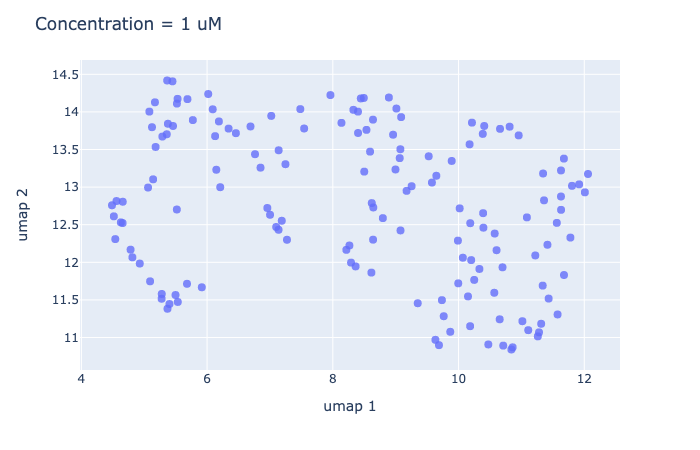

In [8]:
fig = px.scatter(data_frame=X_1_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 opacity=0.8,
                 hover_name='Compound')
fig.update_traces(marker=dict(size=8))
fig.update_layout(title=f'Concentration = 1 uM',
                  xaxis=dict(title='umap 1'),
                  yaxis=dict(title='umap 2'))
fig.show("png")
fig.write_image('figures/4.umap_conc_1.png', height=480, width=640, scale=2)

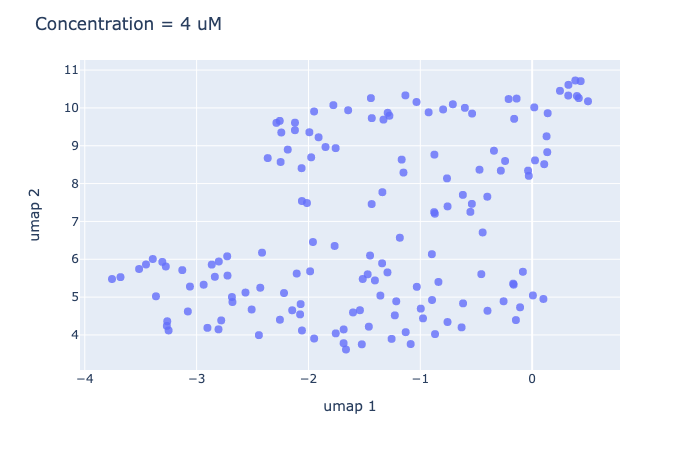

In [9]:
fig = px.scatter(data_frame=X_4_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 opacity=0.8,
                 hover_name='Compound')
fig.update_traces(marker=dict(size=8))
fig.update_layout(title=f'Concentration = 4 uM',
                  xaxis=dict(title='umap 1'),
                  yaxis=dict(title='umap 2'))
fig.show("png")
fig.write_image('figures/4.umap_conc_4.png', height=480, width=640, scale=2)

In [10]:
corr = np.corrcoef(X_1, X_4)
sns.set(rc={'figure.figsize': (30,30)})
sns.heatmap(corr, cmap='Blues', square=True)
plt.savefig('figures/4.correlation.png')
plt.close()

In [11]:
pdist = hierarchy.distance.pdist(corr)
linkage = hierarchy.linkage(pdist, method='complete')
hierarchy.dendrogram(linkage, orientation='right')
plt.savefig('figures/4.hierarchical_clustering.png')
plt.close()